In [70]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from io_data import loadSpatialDataset
from analyze import calcUmap, plotUmap
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm
from dataprep import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [4]:
def initializeAdata(data_path = "/media/gambino/students_workdir/nynke/blurry_model/ileum_data/mouse_ileum/coordinate_parsed/*.tif", adata_concat='blurry'):
    adata = loadSpatialDataset(single_gene_images_glob = data_path, adata_to_concat=adata_concat)
    img_paths = adata.obs["original_image_paths"]
    cell_ids = [re.findall('icell(\d+)', img_path)[0] for img_path in img_paths]
    adata.obs['cell_id'] = cell_ids
    return adata

In [5]:
# removing the biological real data from the similated data
#adata_bio = adata
#adata = adata[adata.obs['pattern']!='spatial']
#adata.obs.reset_index(drop=True, inplace=True)

In [3]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")


In [110]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [111]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [34]:
adata

AnnData object with n_obs × n_vars = 1627152 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

In [41]:
adata.obs['random_or_pattern'] = adata.obs['random_or_pattern'].replace('no_pattern','random')
adata.obs['pattern'] = adata.obs['pattern'].replace('no_pattern','random')

In [5]:
adata_strong = adata[adata.obs['pattern_strength']=='strong']

In [50]:
adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

# Random Forest

## Pattern / no pattern

In [11]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

#out of bag score during training
rf_classifier.oob_score_

0.9615854448536897

Make random the desired pattern to score on, so that the F1 will be selecting for the best true negative. 

In [51]:
adata_train_labels = adata_train.copy()
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [52]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5,6]}
f_scorer_precision = make_scorer(fbeta_score, beta=0.5) # 0.5 -> precision 2x as important as recall, when scoring on TP, FP is punished harder than FN. 

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring=f_scorer_precision, verbose=3, error_score='raise')
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................max_features=2;, score=0.947 total time= 1.2min
[CV 2/5] END ....................max_features=2;, score=0.976 total time= 1.2min
[CV 3/5] END ....................max_features=2;, score=0.972 total time= 1.3min
[CV 4/5] END ....................max_features=2;, score=0.974 total time= 1.2min
[CV 5/5] END ....................max_features=2;, score=0.975 total time= 1.2min
[CV 1/5] END ....................max_features=3;, score=0.947 total time= 1.7min
[CV 2/5] END ....................max_features=3;, score=0.976 total time= 1.6min
[CV 3/5] END ....................max_features=3;, score=0.972 total time= 1.8min
[CV 4/5] END ....................max_features=3;, score=0.974 total time= 1.8min
[CV 5/5] END ....................max_features=3;, score=0.975 total time= 1.8min
[CV 1/5] END ....................max_features=4;, score=0.946 total time= 2.2min
[CV 2/5] END ....................max_features=4;,

In [55]:
adata_train_labels = adata_train.copy()
pattern_mapping = {'pattern': 0, 'random': 1}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [56]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5]}
f_scorer_precision = make_scorer(fbeta_score, beta=2) # 0.5 -> precision 2x as important as recall, when scoring on TP, FP is punished harder than FN. But now it is reversed because we say that random is the TP, so we want to reduce FN. 

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring=f_scorer_precision, verbose=3, error_score='raise')
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....................max_features=2;, score=0.702 total time= 1.2min
[CV 2/5] END ....................max_features=2;, score=0.806 total time= 1.2min
[CV 3/5] END ....................max_features=2;, score=0.779 total time= 1.3min
[CV 4/5] END ....................max_features=2;, score=0.786 total time= 1.3min
[CV 5/5] END ....................max_features=2;, score=0.790 total time= 1.2min
[CV 1/5] END ....................max_features=3;, score=0.703 total time= 1.7min
[CV 2/5] END ....................max_features=3;, score=0.807 total time= 1.7min
[CV 3/5] END ....................max_features=3;, score=0.782 total time= 1.9min
[CV 4/5] END ....................max_features=3;, score=0.791 total time= 1.8min
[CV 5/5] END ....................max_features=3;, score=0.794 total time= 1.8min
[CV 1/5] END ....................max_features=4;, score=0.700 total time= 2.3min
[CV 2/5] END ....................max_features=4;,

### Old model, new embeddings, inverted f1 score for scoring

In [ ]:
adata_train_labels = adata_train.copy()
pattern_mapping = {'pattern': 0, 'random': 1}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [ ]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5,6]}

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='f1', verbose=3, error_score='raise')
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....................max_features=2;, score=0.563 total time= 1.2min
[CV 2/5] END ....................max_features=2;, score=0.842 total time= 1.2min
[CV 3/5] END ....................max_features=2;, score=0.803 total time= 1.3min
[CV 4/5] END ....................max_features=2;, score=0.822 total time= 1.2min
[CV 5/5] END ....................max_features=2;, score=0.843 total time= 1.2min
[CV 1/5] END ....................max_features=3;, score=0.564 total time= 1.7min
[CV 2/5] END ....................max_features=3;, score=0.841 total time= 1.6min
[CV 3/5] END ....................max_features=3;, score=0.805 total time= 1.8min
[CV 4/5] END ....................max_features=3;, score=0.826 total time= 1.8min
[CV 5/5] END ....................max_features=3;, score=0.846 total time= 1.8min
[CV 1/5] END ....................max_features=4;, score=0.558 total time= 2.2min
[CV 2/5] END ....................max_features=4;,

In [25]:
train_accuracy = []
test_accuracy = []
for count in tqdm(range(50, 401, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=3, bootstrap=True, oob_score=True)
    rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict(adata_train.obsm["latent"])
    test_pred = rf_classifier.predict(adata_test.obsm["latent"])

    # Obtain training and validation F1 score. 
    train_f1 = f1_score(adata_train.obs["random_or_pattern"], train_pred, pos_label='random')
    test_f1 = f1_score(adata_test.obs["random_or_pattern"], test_pred, pos_label='random')

    #append scores to lists
    train_accuracy.append(train_f1)
    test_accuracy.append(test_f1)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [42:23<00:00, 317.88s/it]


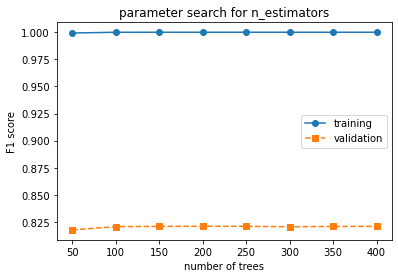

In [26]:
plt.figure()

x_values = range(50, 401, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o')
plt.plot(x_values, test_accuracy, label='validation', linestyle='--', marker='s')

# Add labels and legend
plt.title('parameter search for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [27]:
test_accuracy

[0.8175692332977237,
 0.8205843729481287,
 0.8208324789829814,
 0.8209689318796622,
 0.8208722741433022,
 0.820477088285925,
 0.8207926479035037,
 0.8208410256410257]

There is hardly any improvement with more trees in the random forest, stays at 97.5%.

In [28]:
 # create random forest classifier and fit on training data
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
#predict label
test_pred = rf_classifier.predict(adata_test.obsm["latent"])

In [29]:
import pickle

In [30]:
rf_pattern = rf_classifier
path = f"temp_objects/rf_pattern.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pattern, f)

f1 score: 
0.9776156490642021


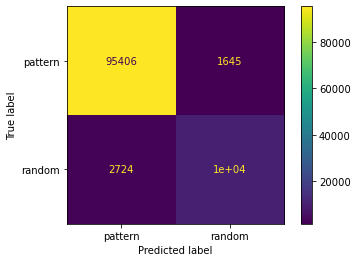

In [31]:
print("f1 score: ")
print(f1_score(adata_test.obs["random_or_pattern"], test_pred, pos_label='pattern'))

confusion_matrix = metrics.confusion_matrix(adata_test.obs["random_or_pattern"], test_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

f1 score: 
0.9768739910062691


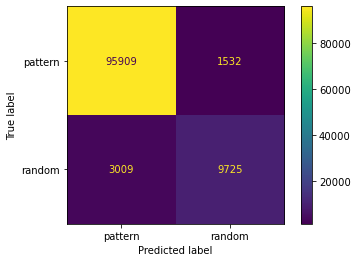

In [ ]:
print("f1 score: ")
print(f1_score(adata_test.obs["random_or_pattern"], test_pred, pos_label='pattern'))

confusion_matrix = metrics.confusion_matrix(adata_test.obs["random_or_pattern"], test_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

See the ratio of pattern/non pattern that the RF classifies the real biological data

In [18]:
bio_pred = rf_classifier.predict(adata_bio[adata_bio.obs['pattern']=='spatial'].obsm["latent"])
np.unique(bio_pred, return_counts=True)

(array(['pattern', 'random'], dtype=object), array([2956,  558]))

## Random Forest Multilabel

run the random forest for optimal parameters and get F1 score.
select only the pattern ones, and then do random forest on the pattern labels. 
In the end wanna do a for loop to combine the combinations between the different ones. random forest + other stuff etc. 

In [19]:
adata_val.obs['pattern']

1236      cell-edge
1237      cell-edge
1238      cell-edge
1239      cell-edge
1240      cell-edge
            ...    
542172       random
542173       random
542174       random
542175       random
542176       random
Name: pattern, Length: 110181, dtype: object

In [25]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_test_pattern = adata_val.copy()
adata_test_pattern = adata_test_pattern[adata_test_pattern.obs['pattern']!='random']

#pattern_mapping = {'pattern': 1, 'random': 0}
#adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [ ]:
# multilabel RF including random
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["pattern"])

#predict label
test_pred = rf_classifier.predict(adata_val.obsm["latent"])

print("class labels")
print(adata_val.obs["pattern"].unique())   
print('f1 validation: per class:')
print(f1_score(adata_val.obs["pattern"], test_pred, average=None))
 
#confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["pattern"], test_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=adata_val.obs["pattern"], y_pred=test_pred, display_labels = rf_classifier.classes_, xticks_rotation='vertical') 
cm_display.plot()

In [ ]:
test_f1_macro = f1_score(adata_val.obs["pattern"], test_pred, average='macro')
test_f1_micro = f1_score(adata_val.obs["pattern"], test_pred, average='micro')
print('f1 validation: macro average:')
print(test_f1_macro)
print('f1 validation: micro average:')
print(test_f1_micro)

f1 validation: macro average:
0.7973921154387781
f1 validation: micro average:
0.7886044591246903


In [22]:
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["pattern"])

#predict label
test_pred = rf_classifier.predict(adata_test_pattern.obsm["latent"])

In [23]:
test_f1_macro = f1_score(adata_test_pattern.obs["pattern"], test_pred, average='macro')
test_f1_micro = f1_score(adata_test_pattern.obs["pattern"], test_pred, average='micro')
test_f1_per_class = f1_score(adata_test_pattern.obs["pattern"], test_pred, average=None)
print('f1 validation: macro average:')
print(test_f1_macro)
print('f1 validation: micro average:')
print(test_f1_micro)
print('f1 validation: per class:')
print(test_f1_per_class)
print("class labels")
print(adata_test_pattern.obs["pattern"].unique())    

f1 validation: macro average:
0.7916347275410223
f1 validation: micro average:
0.7875973606165402
f1 validation: per class:
[0.72545571 0.64150943 0.6535095  0.88301857 0.86769158 0.8988764
 0.81553317 0.84748345]
class labels
['cell-edge' 'extranuclear' 'foci' 'intranuclear' 'nuclear-edge'
 'pericellular' 'perinuclear' 'protrusion']


In [ ]:
test_f1_macro = f1_score(adata_test_pattern.obs["pattern"], test_pred, average='macro')
test_f1_micro = f1_score(adata_test_pattern.obs["pattern"], test_pred, average='micro')
test_f1_per_class = f1_score(adata_test_pattern.obs["pattern"], test_pred, average=None)
print('f1 validation: macro average:')
print(test_f1_macro)
print('f1 validation: micro average:')
print(test_f1_micro)
print('f1 validation: per class:')
print(test_f1_per_class)
print("class labels")
print(adata_test_pattern.obs["pattern"].unique())    

f1 validation: macro average:
0.8114944706943449
f1 validation: micro average:
0.8019948051948051
f1 validation: per class:
[0.73604453 0.64076646 0.69004525 0.88293526 0.8653607  0.90095639
 0.81456841 0.96127877]
class labels
['cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'protrusion']
Categories (8, object): ['cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'protrusion']


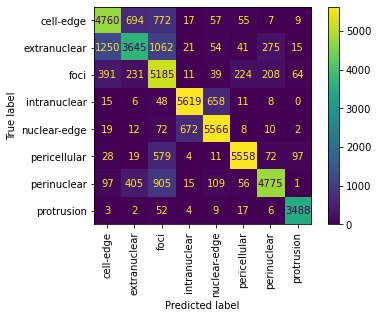

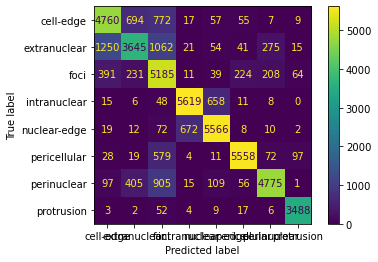

In [ ]:
#confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["pattern"], test_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=adata_test_pattern.obs["pattern"], y_pred=test_pred, display_labels = rf_classifier.classes_, xticks_rotation='vertical') 
cm_display.plot()

In [ ]:
adata_train.obs[adata_train.obs['pattern']=='protrusion']

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths
441923,protrusion,pattern,46,40-50,187,blank,22,0-60,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
441924,protrusion,pattern,46,40-50,187,blank,232,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
441925,protrusion,pattern,46,40-50,187,blank,244,240-300,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
441926,protrusion,pattern,46,40-50,187,blank,267,240-300,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
441927,protrusion,pattern,46,40-50,187,blank,6,0-60,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478193,protrusion,pattern,79,80-90,177,blank,33,0-60,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
478881,protrusion,pattern,38,30-40,177,blank,172,120-180,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
478882,protrusion,pattern,38,30-40,177,blank,192,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...
478883,protrusion,pattern,38,30-40,177,blank,317,300+,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/all_...,train,/mnt/data/david/simulated_cells/with_dapi/all_...


In [ ]:
bio_pred = rf_classifier.predict(adata_bio[adata_bio.obs['pattern']=='spatial'].obsm["latent"])
np.unique(bio_pred, return_counts=True)

(array(['cell-edge', 'extranuclear', 'intranuclear', 'pericellular',
        'perinuclear'], dtype=object),
 array([1435,  488,  679,  678,  234]))

Classifier score for pattern classifier that has mixed cell_id's. 

In [26]:
#out of bag score during training
rf_classifier.oob_score_

0.8450290080207971

## Random Forest - Separate Binary classifiers

In [7]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_test_pattern = adata_test.copy()
adata_test_pattern = adata_test_pattern[adata_test_pattern.obs['pattern']!='random']

In [8]:
adata_train_pattern.obs["cell-edge"] = np.where(adata_train_pattern.obs["pattern"] == "cell-edge", "cell-edge", "other")
adata_test_pattern.obs["cell-edge"] = np.where(adata_test_pattern.obs["pattern"] == "cell-edge", "cell-edge", "other")

adata_train_pattern.obs["extranuclear"] = np.where(adata_train_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")
adata_test_pattern.obs["extranuclear"] = np.where(adata_test_pattern.obs["pattern"] == "extranuclear", "extranuclear", "other")

adata_train_pattern.obs["foci"] = np.where(adata_train_pattern.obs["pattern"] == "foci", "foci", "other")
adata_test_pattern.obs["foci"] = np.where(adata_test_pattern.obs["pattern"] == "foci", "foci", "other")

adata_train_pattern.obs["intranuclear"] = np.where(adata_train_pattern.obs["pattern"] == "intranuclear", "intranuclear", "other")
adata_test_pattern.obs["intranuclear"] = np.where(adata_test_pattern.obs["pattern"] == "intranuclear", "intranuclear", "other")

adata_train_pattern.obs["nuclear-edge"] = np.where(adata_train_pattern.obs["pattern"] == "nuclear-edge", "nuclear-edge", "other")
adata_test_pattern.obs["nuclear-edge"] = np.where(adata_test_pattern.obs["pattern"] == "nuclear-edge", "nuclear-edge", "other")

adata_train_pattern.obs["pericellular"] = np.where(adata_train_pattern.obs["pattern"] == "pericellular", "pericellular", "other")
adata_test_pattern.obs["pericellular"] = np.where(adata_test_pattern.obs["pattern"] == "pericellular", "pericellular", "other")

adata_train_pattern.obs["perinuclear"] = np.where(adata_train_pattern.obs["pattern"] == "perinuclear", "perinuclear", "other")
adata_test_pattern.obs["perinuclear"] = np.where(adata_test_pattern.obs["pattern"] == "perinuclear", "perinuclear", "other")

adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
adata_test_pattern.obs["protrusion"] = np.where(adata_test_pattern.obs["pattern"] == "protrusion", "protrusion", "other")

<ipython-input-8-f25da67e7bee>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["cell-edge"] = np.where(adata_train_pattern.obs["pattern"] == "cell-edge", "cell-edge", "other")
<ipython-input-8-f25da67e7bee>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_pattern.obs["cell-edge"] = np.where(adata_test_pattern.obs["pattern"] == "cell-edge", "cell-edge", "other")


In [28]:
adata_train_pattern.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,...,train_or_val,original_image_paths,cell-edge,extranuclear,foci,intranuclear,nuclear-edge,pericellular,perinuclear,protrusion
892,cell-edge,pattern,42,40-50,27,blank,154,120-180,1.5,0.9,...,val,/mnt/data/david/simulated_cells/with_dapi/all_...,cell-edge,other,other,other,other,other,other,other
893,cell-edge,pattern,42,40-50,27,blank,186,180-240,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,cell-edge,other,other,other,other,other,other,other
894,cell-edge,pattern,42,40-50,27,blank,276,240-300,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,cell-edge,other,other,other,other,other,other,other
895,cell-edge,pattern,42,40-50,27,blank,320,300+,1.5,0.9,...,val,/mnt/data/david/simulated_cells/with_dapi/all_...,cell-edge,other,other,other,other,other,other,other
896,cell-edge,pattern,42,40-50,27,blank,65,60-120,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,cell-edge,other,other,other,other,other,other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440601,perinuclear,pattern,2,0-10,108,blank,120,60-120,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,other,other,other,other,other,other,perinuclear,other
440602,perinuclear,pattern,2,0-10,108,blank,162,120-180,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,other,other,other,other,other,other,perinuclear,other
440603,perinuclear,pattern,2,0-10,108,blank,231,180-240,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,other,other,other,other,other,other,perinuclear,other
440604,perinuclear,pattern,2,0-10,108,blank,262,240-300,1.5,0.9,...,train,/mnt/data/david/simulated_cells/with_dapi/all_...,other,other,other,other,other,other,perinuclear,other


In [9]:
import pickle

RF excluding random

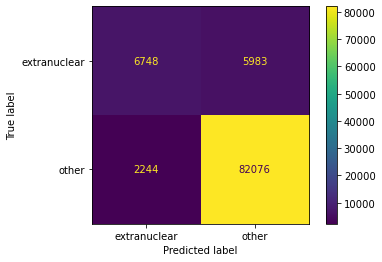

In [10]:
 # create random forest classifier EXCLUDING random
rf_extranuclear = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_extranuclear.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["extranuclear"]) 
    
#predict label
test_extranuclear = rf_extranuclear.predict(adata_test_pattern.obsm["latent"])

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["extranuclear"], test_extranuclear, labels = rf_extranuclear.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_extranuclear.classes_) 
cm_display.plot()
plt.show()

In [19]:
print("f1 score: ", f1_score(adata_test_pattern.obs["extranuclear"], test_extranuclear, pos_label='extranuclear'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["extranuclear"], test_extranuclear, pos_label='other'))

f1 score:  0.6212769875247434
inverted f1 score:  0.9522737688465531


In [32]:
#predict label
test_cell_edge = models.get("cellEdge").predict(adata_test_pattern.obsm["latent"])

print("f1 score: ")
print(f1_score(adata_test_pattern.obs["cell-edge"], test_cell_edge, pos_label='cell-edge'))

f1 score: 
0.725608703160076


f1 score:  0.716413939877627
inverted f1 score:  0.9627159745377387


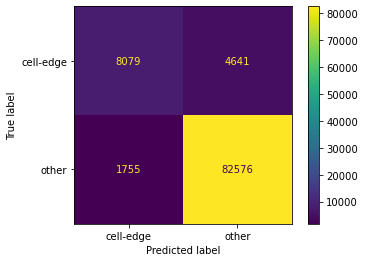

In [12]:
 # create random forest classifier EXCLUDING random
rf_cellEdge = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_cellEdge.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["cell-edge"]) 
    
#predict label
test_cell_edge = rf_cellEdge.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["cell-edge"], test_cell_edge, pos_label='cell-edge'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["cell-edge"], test_cell_edge, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["cell-edge"], test_cell_edge, labels = rf_cellEdge.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_cellEdge.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.6390104985761041
inverted f1 score:  0.9502095852264401


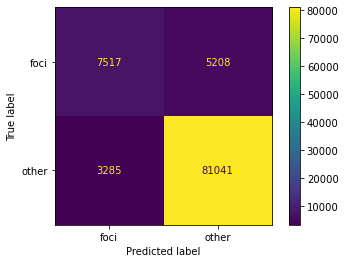

In [13]:
 # create random forest classifier EXCLUDING random
rf_foci = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_foci.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["foci"]) 
    
#predict label
test_foci = rf_foci.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["foci"], test_foci, pos_label='foci'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["foci"], test_foci, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["foci"], test_foci, labels = rf_foci.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_foci.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.8857550186876276
inverted f1 score:  0.8857550186876276


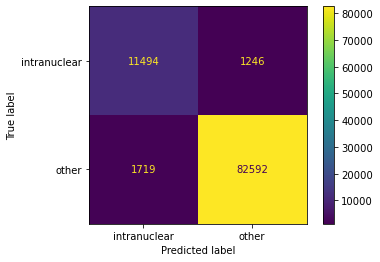

In [14]:
 # create random forest classifier EXCLUDING random
rf_intranuclear = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_intranuclear.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["intranuclear"]) 
    
#predict label
test_intranuclear = rf_intranuclear.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["intranuclear"], test_intranuclear, pos_label='intranuclear'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["intranuclear"], test_intranuclear, pos_label='intranuclear'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["intranuclear"], test_intranuclear, labels = rf_intranuclear.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_intranuclear.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.8670022734654108
inverted f1 score:  0.9806691449814127


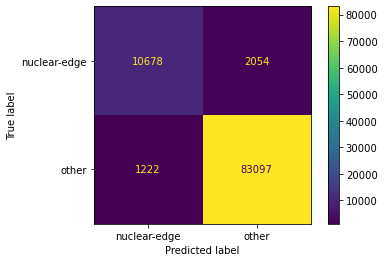

In [15]:
 # create random forest classifier EXCLUDING random
rf_nuclearEdge = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_nuclearEdge.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["nuclear-edge"]) 
    
#predict label
test_nuclear_edge = rf_nuclearEdge.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["nuclear-edge"], test_nuclear_edge, pos_label='nuclear-edge'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["nuclear-edge"], test_nuclear_edge, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["nuclear-edge"], test_nuclear_edge, labels = rf_nuclearEdge.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_nuclearEdge.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.8670022734654108
inverted f1 score:  0.9883193381154414


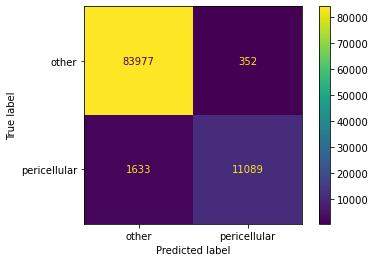

In [16]:
 # create random forest classifier EXCLUDING random
rf_pericellular = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_pericellular.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["nuclear-edge"], test_nuclear_edge, pos_label='nuclear-edge'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["pericellular"], test_pericellular, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["pericellular"], test_pericellular, labels = rf_pericellular.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_pericellular.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.8041682551785486
inverted f1 score:  0.8041682551785486


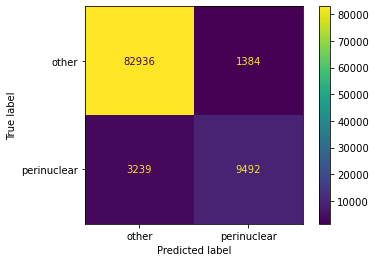

In [17]:
 # create random forest classifier EXCLUDING random
rf_perinuclear = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_perinuclear.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["perinuclear"]) 
    
#predict label
test_perinuclear = rf_perinuclear.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["perinuclear"], test_perinuclear, pos_label='perinuclear'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["perinuclear"], test_perinuclear, pos_label='perinuclear'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["perinuclear"], test_perinuclear, labels = rf_perinuclear.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_perinuclear.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.8041682551785486
inverted f1 score:  0.9892667772954067


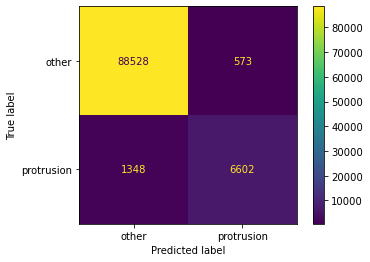

In [18]:
 # create random forest classifier EXCLUDING random
rf_protrusion = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_protrusion.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["protrusion"]) 
    
#predict label
test_protrusion = rf_protrusion.predict(adata_test_pattern.obsm["latent"])

print("f1 score: ", f1_score(adata_test_pattern.obs["perinuclear"], test_perinuclear, pos_label='perinuclear'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["protrusion"], test_protrusion, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["protrusion"], test_protrusion, labels = rf_protrusion.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_protrusion.classes_) 
cm_display.plot()
plt.show()

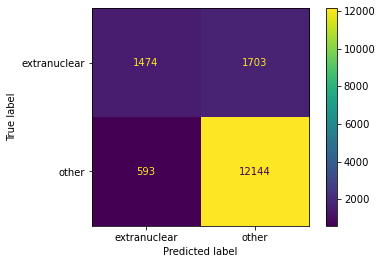

In [35]:
confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["extranuclear_no_random"], test_pred, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

## Saving and restoring RF objects

In [ ]:
import pickle
patterns = {'cellEdge': rf_cellEdge, 'foci': rf_foci, 'extranuclear': rf_extranuclear, 'intranuclear': rf_intranuclear, 'nuclearEdge': rf_nuclearEdge, 'pericellular': rf_pericellular, 'perinuclear': rf_perinuclear, 'protrusion': rf_protrusion}

for key, value in patterns.items():
    path = f"temp_objects/f1_negative_cellID_split/rf_{key}.pkl"

    # Open the file in write-binary mode and dump the object
    with open(path, 'wb') as f:
        pickle.dump(value, f)

In [144]:
import pickle

patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
models = {}

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/f1_negative_cellID_split/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        models[pattern] = pickle.load(p)

## 1 gene n cells

### F1 exploration

In [9]:
counts = adata.obs['n_spots_interval'].unique()
pattern_strength = adata.obs['pattern_strength'].unique()

In [13]:
for count in counts:
    adata_count = adata[adata.obs['n_spots_interval']==count]
    rf_score = models['pattern'].predict(adata_count.obsm["latent"])

    print(f"f1 score for {count}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))
    print(f"inverse f1 score for {count}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='no_pattern'))

    confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = models['pattern'].classes_) 
    cm_display.plot()
    plt.savefig(f'images/confusion_matrix/pattern_nopattern/total/new_embeddings/pattern_{count}.png')
    plt.close()

f1 score for 100+:  0.7695910665356976
inverse f1 score for 100+:  0.40117378966377154
f1 score for 0-10:  0.9303119433282241
inverse f1 score for 0-10:  0.4078845476944738
f1 score for 10-20:  0.870513692345887
inverse f1 score for 10-20:  0.36786636454655636
f1 score for 20-30:  0.8394893152181335
inverse f1 score for 20-30:  0.37412370219185376
f1 score for 30-40:  0.8149536397711581
inverse f1 score for 30-40:  0.37749843847595255
f1 score for 40-50:  0.8052834056993385
inverse f1 score for 40-50:  0.39768192006997977
f1 score for 50-60:  0.7918112171147731
inverse f1 score for 50-60:  0.384530465439265
f1 score for 70-80:  0.786311796392874
inverse f1 score for 70-80:  0.38542749881030014
f1 score for 80-90:  0.7794282784884289
inverse f1 score for 80-90:  0.38072718549741275
f1 score for 90-100:  0.776207548559782
inverse f1 score for 90-100:  0.3988258187934958


In [16]:
adata[adata.obs['pattern']=='random'].obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths,pattern_strength
1437959,random,random,100,100+,151,blank,138,120-180,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437960,random,random,100,100+,151,blank,168,120-180,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437961,random,random,100,100+,151,blank,186,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437962,random,random,100,100+,151,blank,309,300+,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437963,random,random,100,100+,151,blank,97,60-120,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627147,random,random,9,0-10,308,blank,154,120-180,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate
1627148,random,random,9,0-10,308,blank,168,120-180,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate
1627149,random,random,9,0-10,308,blank,230,180-240,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate
1627150,random,random,9,0-10,308,blank,281,240-300,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate


In [47]:
for strength in pattern_strength:
    for count in counts:

        adata_count = adata[(adata.obs['n_spots_interval']==count)&(((adata.obs['pattern_strength']==strength) & (adata.obs['random_or_pattern']=='pattern'))|(adata.obs['random_or_pattern']=='random'))]
        rf_score = models['pattern'].predict(adata_count.obsm["latent"])

        print(f"f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))
        print(f"inverse f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random'))

        confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Pattern', 'No Pattern']) 
        cm_display.plot()
        plt.savefig(f'images/confusion_matrix/pattern_{strength}_{count}.png')
        plt.close()

f1 score for 0-10 & strong:  0.882816202188875
inverse f1 score for 0-10 & strong:  0.5273505051424411


f1 score for 10-20 & strong:  0.911378009541773
inverse f1 score for 10-20 & strong:  0.6860259433962265
f1 score for 20-30 & strong:  0.9365355543512365
inverse f1 score for 20-30 & strong:  0.7912170404429015
f1 score for 30-40 & strong:  0.9480544430815612
inverse f1 score for 30-40 & strong:  0.8462043316560927
f1 score for 40-50 & strong:  0.9639294620591378
inverse f1 score for 40-50 & strong:  0.8998020781791192
f1 score for 50-60 & strong:  0.9703899238253262
inverse f1 score for 50-60 & strong:  0.9166772783225096
f1 score for 70-80 & strong:  0.9766690595836325
inverse f1 score for 70-80 & strong:  0.9334130100734164
f1 score for 80-90 & strong:  0.9808027403380744
inverse f1 score for 80-90 & strong:  0.9451699349185418
f1 score for 90-100 & strong:  0.9843268708099293
inverse f1 score for 90-100 & strong:  0.9588454523828404
f1 score for 100+ & strong:  0.9886345149333112
inverse f1 score for 100+ & strong:  0.9704802085432527
f1 score for 0-10 & intermediate:  0.8523373052

In [ ]:
adata.obs['n_spots_interval'].unique()

['100+', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '70-80', '80-90', '90-100']
Categories (10, object): ['0-10' < '10-20' < '20-30' < '30-40' ... '70-80' < '80-90' < '90-100' < '100+']

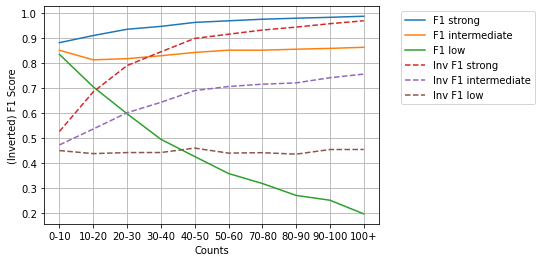

In [33]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the F1 scores
pattern_strength = ['strong', 'intermediate', 'low']
f1_scores = {strength: [] for strength in pattern_strength}
inv_f1_scores = {strength: [] for strength in pattern_strength}
counts = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '70-80', '80-90', '90-100', '100+']

for strength in pattern_strength:
    for count in counts:
        adata_count = adata[(adata.obs['n_spots_interval'] == count) & (((adata.obs['pattern_strength'] == strength) & (adata.obs['random_or_pattern'] == 'pattern')) | (adata.obs['random_or_pattern'] == 'random'))]
        rf_score = models['pattern'].predict(adata_count.obsm["latent"])
        f1 = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern')
        inv_f1 = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random')
        f1_scores[strength].append(f1)
        inv_f1_scores[strength].append(inv_f1)

# Create the plot
for strength, scores in f1_scores.items():
    plt.plot(counts, scores, label=f'F1 {strength}')
for strength, scores in inv_f1_scores.items():
    plt.plot(counts, scores, linestyle='--', label=f'Inv F1 {strength}')

plt.xlabel('Counts')
plt.ylabel('(Inverted) F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True) 
plt.show()

In [ ]:
f1 = {}
inv_f1 = {}
for strength in pattern_strength:
    for count in counts:

        adata_count = adata[(adata.obs['n_spots_interval']==count)&(((adata.obs['pattern_strength']==strength) & (adata.obs['random_or_pattern']=='pattern'))|(adata.obs['random_or_pattern']=='random'))]
        rf_score = models['pattern'].predict(adata_count.obsm["latent"])

        print(f"f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))
        print(f"inverse f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random'))


f1 score for 100+ & strong:  0.9886345149333112
inverse f1 score for 100+ & strong:  0.9704802085432527
f1 score for 0-10 & strong:  0.882816202188875
inverse f1 score for 0-10 & strong:  0.5273505051424411
f1 score for 10-20 & strong:  0.911378009541773
inverse f1 score for 10-20 & strong:  0.6860259433962265
f1 score for 20-30 & strong:  0.9365355543512365
inverse f1 score for 20-30 & strong:  0.7912170404429015
f1 score for 30-40 & strong:  0.9480544430815612
inverse f1 score for 30-40 & strong:  0.8462043316560927
f1 score for 40-50 & strong:  0.9639294620591378
inverse f1 score for 40-50 & strong:  0.8998020781791192
f1 score for 50-60 & strong:  0.9703899238253262
inverse f1 score for 50-60 & strong:  0.9166772783225096
f1 score for 70-80 & strong:  0.9766690595836325
inverse f1 score for 70-80 & strong:  0.9334130100734164
f1 score for 80-90 & strong:  0.9808027403380744
inverse f1 score for 80-90 & strong:  0.9451699349185418
f1 score for 90-100 & strong:  0.9843268708099293
in

### Statistics 1 gene n cells

In [71]:
pericellular_dict_low = subsetGenes(adata, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')
pericellular_dict_high = subsetGenes(adata, 'pericellular', pattern_strength=0.9, count_threshold = 100, high_or_low = 'high')
random_dict_low = subsetGenes(adata, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)
random_dict_high = subsetGenes(adata, 'random', count_threshold = 100, high_or_low = 'high', mixed_counts=False)
pattern_dict_low = subsetGenes(adata, mixed_patterns = True, pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')
pattern_dict_high = subsetGenes(adata, mixed_patterns = True, pattern_strength = 0.9, count_threshold = 100, high_or_low = 'high')

In [105]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_low = models.get(pattern).predict_proba(pericellular_dict_low.get(i).obsm["latent"])[:,0]
        pericellular_high = models.get(pattern).predict_proba(pericellular_dict_high.get(i).obsm["latent"])[:,0]
        random_low = models.get(pattern).predict_proba(random_dict_low.get(i).obsm["latent"])[:,0]
        random_high = models.get(pattern).predict_proba(random_dict_high.get(i).obsm["latent"])[:,0]
        pattern_low = models.get(pattern).predict_proba(pattern_dict_low.get(i).obsm["latent"])[:,0]
        pattern_high = models.get(pattern).predict_proba(pattern_dict_high.get(i).obsm["latent"])[:,0]
        for value in pericellular_low:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
        for value in pericellular_high: 
            rows.append({'prob_pattern': value, 'group': 'pericellular_high', 'RF_Classifier': pattern, 'gene_id': i})
        for value in random_low:
            rows.append({'prob_pattern': value, 'group': 'random_low', 'RF_Classifier': pattern, 'gene_id': i})
        for value in random_high:
            rows.append({'prob_pattern': value, 'group': 'random_high', 'RF_Classifier': pattern, 'gene_id': i})
        for value in pattern_low:
            rows.append({'prob_pattern': value, 'group': 'pattern_low', 'RF_Classifier': pattern, 'gene_id': i})
        for value in pattern_high:
            rows.append({'prob_pattern': value, 'group': 'pattern_high', 'RF_Classifier': pattern, 'gene_id': i})
df = pd.DataFrame(rows)

In [100]:
test = df[df['group']=='pattern_low']
test = test[test['RF_Classifier']=='pericellular']
test['prob_pattern'].mean()

0.8716908517350158

In [104]:
test = df[df['group']=='pericellular']
test = test[test['RF_Classifier']=='pericellular']
test['prob_pattern'].mean()

0.3252483660130719

In [107]:
df['group'].unique()

array(['pericellular_low', 'pericellular_high', 'random_low',
       'random_high', 'pattern_low', 'pattern_high'], dtype=object)

In [113]:
pericellular_dict_low.get(9).obs['prop'].unique()

array([0.9])

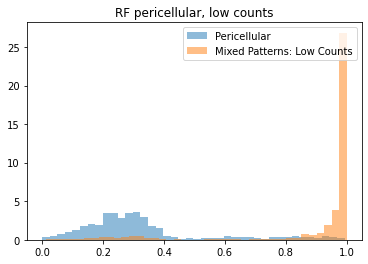

In [62]:
pattern = 'pericellular'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular')]
pattern_low = df[(df['pattern'] == pattern) & (df['group']=='pattern_low')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='random_low')]

plt.hist(pericellular['prob_pattern'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(pattern_low['prob_pattern'], bins=40, alpha=0.5, label='Mixed Patterns: Low Counts', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title(f"RF {pattern}, low counts")
plt.legend(loc='upper right')
plt.show()

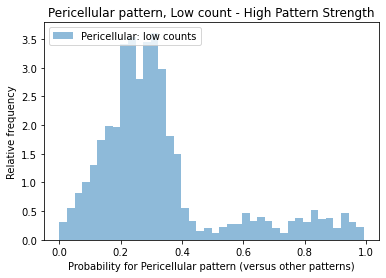

In [108]:
pattern = df[(df['RF_Classifier'] == 'pericellular') & (df['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular pattern, Low count - High Pattern Strength")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## see if I get the old graph if I go with the old data through this RF

In [147]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [148]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata_all.obs['prop'] == 0.9) | ((adata_all.obs['prop'] == 0.4) & (adata_all.obs['pattern'] == 'protrusion')),
    (adata_all.obs['prop'] == 0.5) | ((adata_all.obs['prop'] == 0.2) & (adata_all.obs['pattern'] == 'protrusion')),
    (adata_all.obs['prop'] == 0.1) | ((adata_all.obs['prop'] == 0.0) & (adata_all.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata_all.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [149]:
pericellular_dict_low_all = subsetGenes(adata_all, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [150]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_low_all = models.get(pattern).predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,0]
        for value in pericellular_low:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
df_all_spots_new_model = pd.DataFrame(rows)

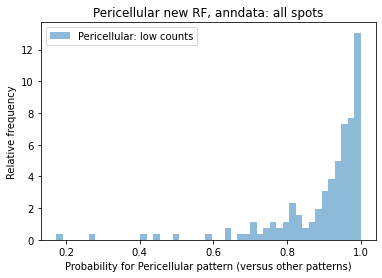

In [162]:
pattern = df_all_spots_new_model[(df_all_spots_new_model['RF_Classifier'] == 'pericellular') & (df_all_spots_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, anndata: all spots")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

### Old custom panel

In [155]:
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [156]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata_mixed_cellID.obs['prop'] == 0.9) | ((adata_mixed_cellID.obs['prop'] == 0.4) & (adata_mixed_cellID.obs['pattern'] == 'protrusion')),
    (adata_mixed_cellID.obs['prop'] == 0.5) | ((adata_mixed_cellID.obs['prop'] == 0.2) & (adata_mixed_cellID.obs['pattern'] == 'protrusion')),
    (adata_mixed_cellID.obs['prop'] == 0.1) | ((adata_mixed_cellID.obs['prop'] == 0.0) & (adata_mixed_cellID.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata_mixed_cellID.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [157]:
pericellular_dict_mixed_cellID = subsetGenes(adata_mixed_cellID, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [158]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_mixed_cellID = models.get(pattern).predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,0]
        for value in pericellular_mixed_cellID:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
df_test2 = pd.DataFrame(rows)

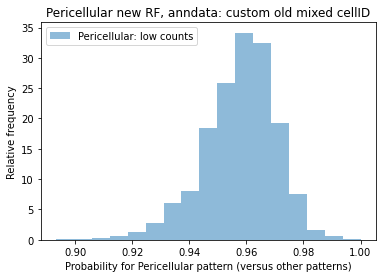

In [163]:
pattern = df_test2[(df_test2['RF_Classifier'] == 'pericellular') & (df_test2['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Reproducing new data

In [164]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [165]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [166]:
pericellular_dict_new = subsetGenes(adata, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [167]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_new = models.get(pattern).predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,0]
        for value in pericellular_new:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
df_new = pd.DataFrame(rows)

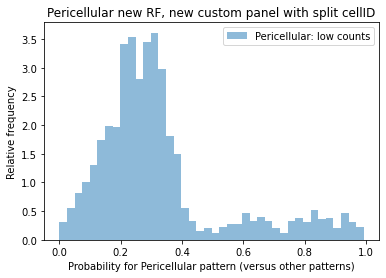

In [178]:
pattern = df_new[(df_new['RF_Classifier'] == 'pericellular') & (df_new['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Test old model see what comes out

In [143]:
import pickle

patterns = ['pericellular']

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        peri_model = pickle.load(p)

In [169]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_old_rf = peri_model.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,0]
    for value in all_spots_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_old_model = pd.DataFrame(rows)

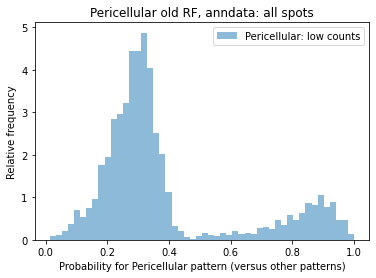

In [182]:
pattern = df_all_spots_old_model[(df_all_spots_old_model['RF_Classifier'] == 'pericellular') & (df_all_spots_old_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: all spots")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [170]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_old_rf = peri_model.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,0]
    for value in mixed_cellID_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_new_model = pd.DataFrame(rows)

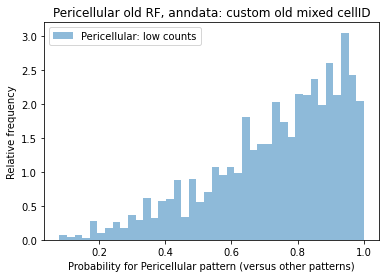

In [174]:
pattern = df_mixed_cellID_new_model[(df_mixed_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [171]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_old_rf = peri_model.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,0]
    for value in split_cellID_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_new_model = pd.DataFrame(rows)

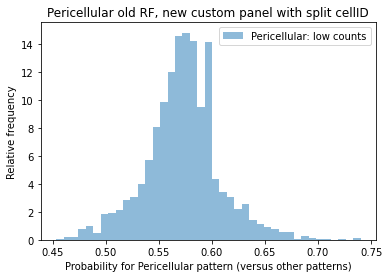

In [183]:
pattern = df_split_cellID_new_model[(df_split_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Train pericellular binary RF including random to see if it is a bit more robust

In [184]:
adata_train.obs['pattern'].unique()

['cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'random', 'protrusion']
Categories (9, object): ['cell-edge', 'extranuclear', 'foci', 'intranuclear', ..., 'pericellular', 'perinuclear', 'protrusion', 'random']

In [185]:
adata_train.obs["pericellular"] = np.where(adata_train.obs["pattern"] == "pericellular", "pericellular", "other")
adata_test.obs["pericellular"] = np.where(adata_test.obs["pattern"] == "pericellular", "pericellular", "other")

<ipython-input-185-c1f34b7ebd3f>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs["pericellular"] = np.where(adata_train.obs["pattern"] == "pericellular", "pericellular", "other")
<ipython-input-185-c1f34b7ebd3f>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs["pericellular"] = np.where(adata_test.obs["pattern"] == "pericellular", "pericellular", "other")


In [187]:
 # create random forest classifier INCLUDING random
rf_pericellular = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=4, bootstrap=True, oob_score=False)
rf_pericellular.fit(adata_train.obsm["latent"], adata_train.obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular.predict(adata_test.obsm["latent"])

print("f1 score: ", f1_score(adata_test.obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["pericellular"], test_pericellular, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["pericellular"], test_pericellular, labels = rf_pericellular.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_pericellular.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.9846105404022514


NameError: name 'adata_test_pattern' is not defined

In [188]:
print("f1 score: ", f1_score(adata_test.obs["pericellular"], test_pericellular, pos_label='pericellular'))

f1 score:  0.9846105404022514


In [189]:
print("inverted f1 score: ", f1_score(adata_test.obs["pericellular"], test_pericellular, pos_label='other'))

inverted f1 score:  0.9979861865790408


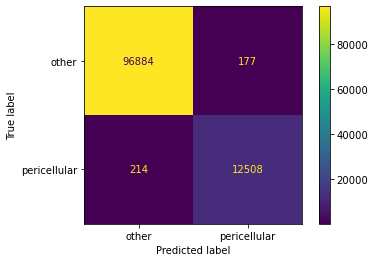

In [190]:
confusion_matrix = metrics.confusion_matrix(adata_test.obs["pericellular"], test_pericellular, labels = rf_pericellular.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_pericellular.classes_) 
cm_display.plot()
plt.show()

In [216]:
import pickle

path = f"temp_objects/incl_random/rf_pericellular.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pericellular, f)

In [191]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_random_rf = rf_pericellular.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,0]
    for value in all_spots_random_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_random_model = pd.DataFrame(rows)

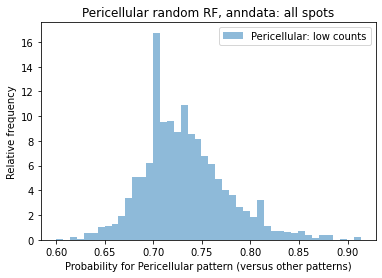

In [192]:
pattern = df_all_spots_random_model[(df_all_spots_random_model['RF_Classifier'] == 'pericellular') & (df_all_spots_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, anndata: all spots")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [193]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_random_rf = rf_pericellular.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,0]
    for value in mixed_cellID_random_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_random_model = pd.DataFrame(rows)

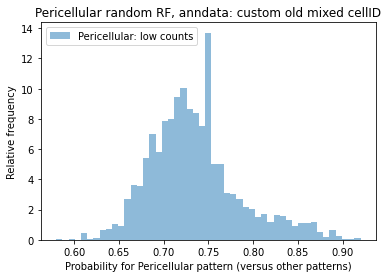

In [194]:
pattern = df_mixed_cellID_random_model[(df_mixed_cellID_random_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [195]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_random_rf = rf_pericellular.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,0]
    for value in split_cellID_random_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_random_model = pd.DataFrame(rows)

In [204]:
len(pattern['prob_pattern'].unique())

142

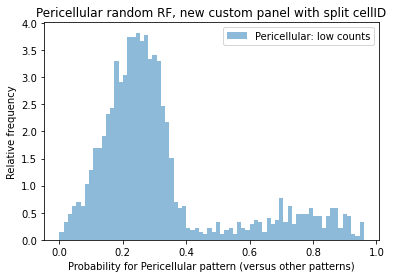

In [215]:
pattern = df_split_cellID_random_model[(df_split_cellID_random_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=72, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

# K - nearest neighbours

Choice of k depends on the input data --> more outliers or noise performs better with a larger k (due to smoothing)

Recommended to have an odd number of k to avoid ties in classification. Use cross-validation to choose optimal k for the dataset.

Rule of thumb: choose a k close to the sqrt(datapoints), aka sqrt(176162)~419

Hyperparameter grid choice. Rule of thumb is that the sqrt(N) will work, and to use odd numbers. Therefore use sqrt as a center and 5 values above and below it. Given that 469 is a relatively large number, will first explore a larger space (i.e. 50 interval in between).

Based on [caching nearest neighbors - scikit-learn tutorial](https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-plot-caching-nearest-neighbors-py) 

### Non-normalized KNN

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=69;, score=0.924 total time= 3.4min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=69;, score=0.928 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 3/5] END ........classifier__n_neighbors=69;, score=0.922 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 4/5] END ........classifier__n_neighbors=69;, score=0.921 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 5/5] END ........classifier__n_neighbors=69;, score=0.927 total time= 3.3min
[CV 1/5] END .......classifier__n_neighbors=119;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifier__n_neighbors=119;, score=0.927 total time=  38.6s
[CV 3/5] END .......classifier__n_neighbors=119;, score=0.922 total time=  38.9s
[CV 4/5] END .......classifier__n_neighbors=119;, score=0.920 total time=  39.4s
[CV 5/5] END .......classifier__n_neighbors=119;, score=0.927 total time=  38.9s
[CV 1/5] END .......classifier__n_neighbors=169;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifier__n_neighbors=169;, score=0.927 total time=  38.7s
[CV 3/5] END .......classifier__n_neighbors=169;, score=0.921 total time=  38.9s
[CV 4/5] END .......classifier__n_neighbors=169;, score=0.920 total time=  39.5s
[CV 5/5] END .......classifier__n_neighbors=169;, score=0.927 total time=  39.0s
[CV 1/5] END .......classifier__n_neighbors=219;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


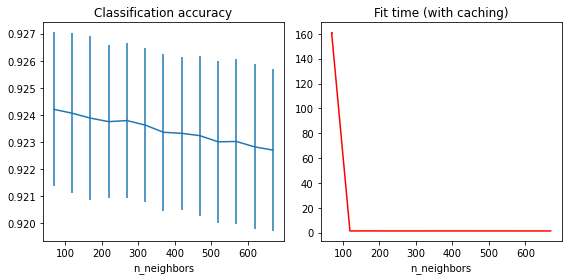

In [10]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

#X, y = load_digits(return_X_y=True)
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3)
    grid_model.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"])

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [70]:
knn_nonnormalized = grid_model.cv_results_
knn_nonnormalized

{'mean_fit_time': array([160.32603569,   1.36809492,   1.39574623,   1.36634436,
          1.364711  ,   1.36581612,   1.37345982,   1.36978893,
          1.366711  ,   1.3668128 ,   1.36542826,   1.36534615,
          1.36573067]),
 'std_fit_time': array([0.85542984, 0.00948896, 0.01288597, 0.01100495, 0.01349895,
        0.01014704, 0.00980585, 0.00822732, 0.01277583, 0.00950512,
        0.01184004, 0.00794088, 0.01065287]),
 'mean_score_time': array([39.81324239, 37.69407601, 37.71695495, 37.73753662, 37.74229832,
        37.76169548, 37.77588997, 37.80055475, 37.80514007, 37.82576494,
        37.88281603, 37.9218977 , 37.94148393]),
 'std_score_time': array([0.66837186, 0.33251339, 0.33180792, 0.33658414, 0.33296387,
        0.33259267, 0.32914207, 0.33045184, 0.33654874, 0.33934595,
        0.31766483, 0.34116603, 0.33493058]),
 'param_classifier__n_neighbors': masked_array(data=[69, 119, 169, 219, 269, 319, 369, 419, 469, 519, 569,
                    619, 669],
              mas

#### Save and load the KNN object 
So that I don't have to rerun it later, and can just get the object to make vizualiations / multiplots. 

In [61]:
np.savez('knn_nonnormalized.npz', **knn_nonnormalized)

In [69]:
load_dict = dict(np.load('knn_nonnormalized.npz', allow_pickle=True))

Text(0.5, 1.0, 'Grid Search Results Non-Normalized Latent Space')

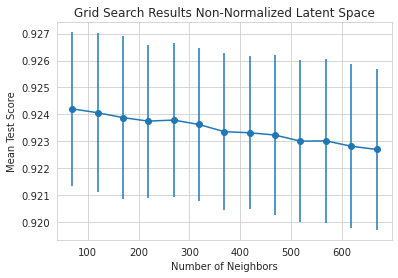

In [68]:
# Code to run the plot from the saved object. The x axis is a bit difficult to get cause it's a masked array, that's why it looks weird
fig, ax = plt.subplots()
ax.errorbar(load_dict.get("param_classifier__n_neighbors").compressed(), load_dict["mean_test_score"], yerr=load_dict['std_test_score'], fmt='-o')
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Mean Test Score")
ax.set_title("Grid Search Results Non-Normalized Latent Space")

Text(0.5, 1.0, 'Grid Search Results')

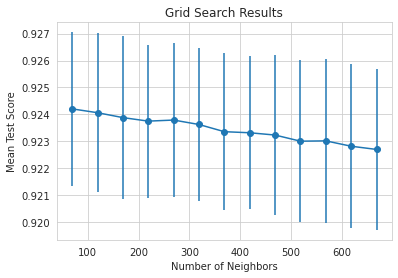

In [22]:
fig, ax = plt.subplots()
ax.errorbar(n_neighbors_list, grid_model.cv_results_["mean_test_score"], yerr=grid_model.cv_results_['std_test_score'], fmt='-o')
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Mean Test Score")
ax.set_title("Grid Search Results Non-Normalized Latent Space")

### Normalized KNN

In [16]:
from scipy import stats
stats.normaltest(adata.obsm['latent'], axis=0)

NormaltestResult(statistic=array([ 2969.539  ,  1722.7858 , 17725.268  , 10980.781  ,   451.94302,
        6556.831  ,  4315.3906 ,  7899.7725 , 15158.62   , 10586.165  ,
       28376.576  ,  2222.5215 , 15285.311  , 25839.836  , 13798.633  ],
      dtype=float32), pvalue=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.27477122e-99, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

normalizing the dimensions and see if that influences the accuracy. Given that none of the latent dimensions are normally distributed, nor are they multivariate normally distributed, we will normalize the latent dimensions using min-max normalization rather than standardization (which assumes the data to be normally distributed)

In [71]:
adata_train2 = adata_train.copy()


In [72]:
adata_train_labels = adata_train.copy()
scaler = MinMaxScaler()
adata_train_labels.obsm['latent']=scaler.fit_transform(adata_train_labels.obsm['latent'])
adata_train_labels.obsm['latent']
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=69;, score=0.947 total time= 4.4min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=69;, score=0.949 total time= 4.5min
[CV 3/5] END ........classifier__n_neighbors=69;, score=0.945 total time= 4.4min
[CV 4/5] END ........classifier__n_neighbors=69;, score=0.945 total time= 4.4min
[CV 5/5] END ........classifier__n_neighbors=69;, score=0.949 total time= 4.5min
[CV 1/5] END .......classifier__n_neighbors=119;, score=0.947 total time=  52.2s
[CV 2/5] END .......classifier__n_neighbors=119;, score=0.949 total time=  50.1s
[CV 3/5] END .......classifier__n_neighbors=119;, score=0.945 total time=  49.6s
[CV 4/5] END .......classifier__n_neighbors=119;, score=0.944 total time=  51.1s
[CV 5/5] END .......classifier__n_neighbors=119;, score=0.949 total time=  51.0s
[CV 1/5] END .......classifier__n_neighbors=169;, score=0.946 total time=  50.8s
[CV 2/5] END .......classifier__n_neighbors=169;, score=0.949 total time=  50.9s
[CV 3/5] END .......classifier__n_neighbors=169;, score=0.945 total time=  50.2s
[CV 4/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.63s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


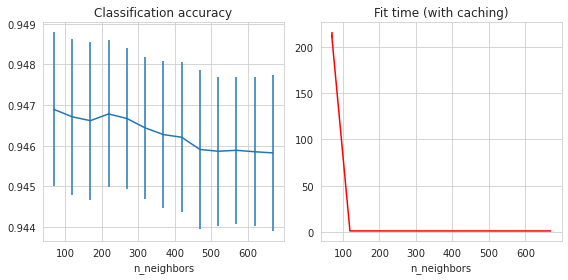

In [73]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1', error_score='raise')
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [74]:
knn_normalized = grid_model.cv_results_
np.savez('knn_normalized.npz', **knn_normalized)

In [75]:
print(grid_model.best_params_)
grid_model.best_score_

{'classifier__n_neighbors': 69}


0.9468950007408262

## Multi-class KNN

Hyperparameter grid around sqrt(157654)~355

In [10]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_test_pattern = adata_val.copy()
adata_test_pattern = adata_test_pattern[adata_test_pattern.obs['pattern']!='random']
#pattern_mapping = {'pattern': 1, 'random': 0}
#adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [11]:
adata_train_pattern.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,pattern_classified,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch
663,cell-edge,pattern,81,90-100,27,blank,307,300+,1.5,NaN,...,cell-edge,0.992096,0.934968,5.487039e-15,1.322831e-10,0.000015,0.967630,0.392781,0.608507,0
664,cell-edge,pattern,81,90-100,27,blank,45,0-60,1.5,NaN,...,extranuclear,0.754152,0.798077,2.422030e-14,2.009141e-09,0.000235,0.627178,0.244180,0.757463,0
665,cell-edge,pattern,81,90-100,27,blank,90,60-120,1.5,NaN,...,cell-edge,0.999964,0.999141,8.410337e-18,1.347031e-07,0.000001,0.035344,0.089089,0.911159,0
897,cell-edge,pattern,24,20-30,27,blank,251,240-300,1.5,NaN,...,random,0.972466,0.127212,2.169975e-11,1.990620e-15,0.000403,1.000000,0.983680,0.016362,0
898,cell-edge,pattern,24,20-30,27,blank,65,60-120,1.5,NaN,...,random,0.004701,0.000760,6.626342e-10,3.418462e-15,0.003140,1.000000,0.945318,0.054801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156222,perinuclear,pattern,27,20-30,108,blank,251,240-300,1.5,NaN,...,perinuclear,0.032426,0.723309,1.660171e-07,1.175373e-04,0.996019,0.033108,0.110164,0.890005,0
156223,perinuclear,pattern,27,20-30,108,blank,332,300+,1.5,NaN,...,extranuclear,0.502149,0.634688,1.423556e-07,4.383508e-05,0.488439,0.412596,0.169994,0.829664,0
156868,perinuclear,pattern,11,10-20,108,blank,100,60-120,1.5,NaN,...,random,0.013130,0.017682,1.378627e-05,2.662874e-08,0.974515,0.998928,0.599384,0.400611,0
156869,perinuclear,pattern,11,10-20,108,blank,168,120-180,1.5,NaN,...,random,0.059709,0.001133,3.874913e-04,1.750608e-06,0.153743,0.999459,0.706572,0.294269,0


In [16]:
adata_train_pattern.obsm['latent']

ArrayView([[-0.3208191 ,  2.8225806 , -1.3590801 , ..., -5.384647  ,
            -8.265151  ,  5.773748  ],
           [-0.40570036,  2.9171438 , -0.9277612 , ..., -5.3958044 ,
            -7.8791065 ,  5.4216666 ],
           [-0.97488296,  3.6805127 , -1.9317566 , ..., -5.5002418 ,
            -7.7567444 ,  5.3031464 ],
           ...,
           [ 2.6768274 ,  2.9809794 , -2.6266003 , ..., -4.2222443 ,
            -7.9422026 ,  7.013573  ],
           [ 1.7666696 ,  2.5898604 , -1.8280711 , ..., -2.933899  ,
            -6.9415245 ,  6.9567447 ],
           [ 1.7096524 ,  2.0780938 , -1.8532205 , ..., -3.107962  ,
            -6.902675  ,  6.38632   ]], dtype=float32)

In [24]:
np.sqrt(125852)

354.7562543493772

We use average='macro', which calculate the F1 score over all the classes, which we do because all patterns have an equal amount of observations, so there is no class imbalance.

In [17]:
scaler = MinMaxScaler()
adata_train_pattern.obsm['latent']=scaler.fit_transform(adata_train_pattern.obsm['latent'])
adata_train_pattern.obsm['latent']

array([[0.5566338 , 0.37366953, 0.31004786, ..., 0.7680447 , 0.387528  ,
        0.34089357],
       [0.5494416 , 0.38041553, 0.3482966 , ..., 0.7675096 , 0.41180426,
        0.30852818],
       [0.5012134 , 0.43487304, 0.2592637 , ..., 0.7625008 , 0.41949895,
        0.2976331 ],
       ...,
       [0.8106315 , 0.38496947, 0.19764595, ..., 0.8237932 , 0.4078365 ,
        0.45486546],
       [0.7335117 , 0.35706764, 0.26845837, ..., 0.88558185, 0.47076374,
        0.44964147],
       [0.7286805 , 0.32055902, 0.2662282 , ..., 0.87723386, 0.47320676,
        0.39720476]], dtype=float32)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=55;, score=0.843 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=55;, score=0.833 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 3/5] END ........classifier__n_neighbors=55;, score=0.844 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 4/5] END ........classifier__n_neighbors=55;, score=0.828 total time= 1.9min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 5/5] END ........classifier__n_neighbors=55;, score=0.846 total time= 2.0min
[CV 1/5] END .......classifier__n_neighbors=105;, score=0.839 total time=  24.1s
[CV 2/5] END .......classifier__n_neighbors=105;, score=0.830 total time=  23.6s
[CV 3/5] END .......classifier__n_neighbors=105;, score=0.841 total time=  23.6s
[CV 4/5] END .......classifier__n_neighbors=105;, score=0.824 total time=  24.0s
[CV 5/5] END .......classifier__n_neighbors=105;, score=0.844 total time=  24.6s
[CV 1/5] END .......classifier__n_neighbors=155;, score=0.837 total time=  24.2s
[CV 2/5] END .......classifier__n_neighbors=155;, score=0.827 total time=  23.6s
[CV 3/5] END .......classifier__n_neighbors=155;, score=0.839 total time=  23.7s
[CV 4/5] END .......classifier__n_neighbors=155;, score=0.823 total time=  24.0s
[CV 5/5] END .......classifier__n_neighbors=155;, score=0.842 total time=  24.4s
[CV 1/5] END .......classifier__n_neighbors=205;, score=0.836 total time=  24.2s
[CV 2/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


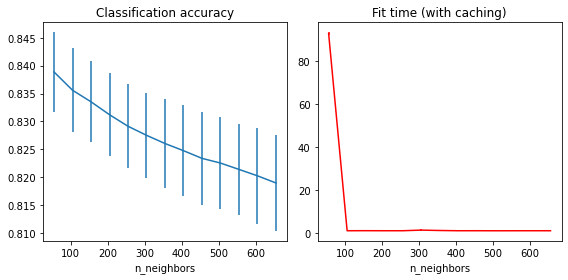

In [18]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_pattern.obsm["latent"]
labels = adata_train_pattern.obs["pattern"]
n_neighbors_list = [55,105,155,205,255,305,355,405,455,505,555,605,655]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1_macro', error_score='raise')
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [20]:
knn_pattern = grid_model.cv_results_
np.savez('knn_patterns.npz', **knn_pattern)